# Importing Libraries

In [1]:
%%capture
!pip install pingouin
!pip install ppscore
!pip install category_encoders

In [4]:
!pip install optuna

In [5]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import pingouin as pg
import ppscore as pps
import statsmodels.api as sm

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, BaggingClassifier

from sklearn.metrics import fbeta_score, confusion_matrix, classification_report


from collections import Counter

import optuna

import warnings
warnings.filterwarnings('ignore')

**Read the dataset**



In [6]:
data = pd.read_csv("Predict_Hair_Fall.csv")

data.head()

,Id,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,133992,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,148393,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,155074,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,118261,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,111915,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


# Preprocessing & EDA

In [7]:
rows, cols = data.shape[0], data.shape[1]

print(f'Rows: {rows}')
print(f'Columns: {cols}')

Rows: 999
Columns: 13


In [8]:
print(data.duplicated().sum())

0


In [9]:
data.isnull().sum()

Id                           0
Genetics                     0
Hormonal Changes             0
Medical Conditions           0
Medications & Treatments     0
Nutritional Deficiencies     0
Stress                       0
Age                          0
Poor Hair Care Habits        0
Environmental Factors        0
Smoking                      0
Weight Loss                  0
Hair Loss                    0
dtype: int64

In [10]:
data = data.drop('Id', axis = 1)

data.head()

,Genetics,Hormonal Changes,Medical Conditions,Medications & Treatments,Nutritional Deficiencies,Stress,Age,Poor Hair Care Habits,Environmental Factors,Smoking,Weight Loss,Hair Loss
0,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [11]:
data.columns = data.columns.str.strip().str.replace(" ", "_")

data.head()

,Genetics,Hormonal_Changes,Medical_Conditions,Medications_&_Treatments,Nutritional_Deficiencies,Stress,Age,Poor_Hair_Care_Habits,Environmental_Factors,Smoking,Weight_Loss,Hair_Loss
0,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [12]:
data_eda = data.copy()

data_eda.head()

,Genetics,Hormonal_Changes,Medical_Conditions,Medications_&_Treatments,Nutritional_Deficiencies,Stress,Age,Poor_Hair_Care_Habits,Environmental_Factors,Smoking,Weight_Loss,Hair_Loss
0,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,0
1,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,0
2,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,0
3,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,0
4,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,1


In [13]:
label_hair = {0:'No', 1:'Yes'}

data_eda['Hair_Loss'] = data_eda['Hair_Loss'].map(label_hair)

data_eda.head()

,Genetics,Hormonal_Changes,Medical_Conditions,Medications_&_Treatments,Nutritional_Deficiencies,Stress,Age,Poor_Hair_Care_Habits,Environmental_Factors,Smoking,Weight_Loss,Hair_Loss
0,Yes,No,No Data,No Data,Magnesium deficiency,Moderate,19,Yes,Yes,No,No,No
1,No,No,Eczema,Antibiotics,Magnesium deficiency,High,43,Yes,Yes,No,No,No
2,No,No,Dermatosis,Antifungal Cream,Protein deficiency,Moderate,26,Yes,Yes,No,Yes,No
3,Yes,Yes,Ringworm,Antibiotics,Biotin Deficiency,Moderate,46,Yes,Yes,No,No,No
4,No,No,Psoriasis,Accutane,Iron deficiency,Moderate,30,No,Yes,Yes,No,Yes


In [14]:
numerical_feature = 'Age'

categorical_features = data_eda.select_dtypes(include = ['object', 'category']).columns.to_list()

In [15]:
print(f'Total categorical features: {len(categorical_features)}')

Total categorical features: 11


In [16]:
for i in categorical_features:
    print(f'{i}: {data[i].unique()}\n')

Genetics: ['Yes' 'No']

Hormonal_Changes: ['No' 'Yes']

Medical_Conditions: ['No Data' 'Eczema' 'Dermatosis' 'Ringworm' 'Psoriasis' 'Alopecia Areata '
 'Scalp Infection' 'Seborrheic Dermatitis' 'Dermatitis' 'Thyroid Problems'
 'Androgenetic Alopecia']

Medications_&_Treatments: ['No Data' 'Antibiotics' 'Antifungal Cream' 'Accutane' 'Chemotherapy'
 'Steroids' 'Rogaine' 'Blood Pressure Medication' 'Immunomodulators'
 'Antidepressants ' 'Heart Medication ']

Nutritional_Deficiencies: ['Magnesium deficiency' 'Protein deficiency' 'Biotin Deficiency '
 'Iron deficiency' 'Selenium deficiency' 'Omega-3 fatty acids'
 'Zinc Deficiency' 'Vitamin A Deficiency' 'Vitamin D Deficiency' 'No Data'
 'Vitamin E deficiency']

Stress: ['Moderate' 'High' 'Low']

Poor_Hair_Care_Habits: ['Yes' 'No']

Environmental_Factors: ['Yes' 'No']

Smoking: ['No' 'Yes']

Weight_Loss: ['No' 'Yes']

Hair_Loss: [0 1]



# Data Visualization

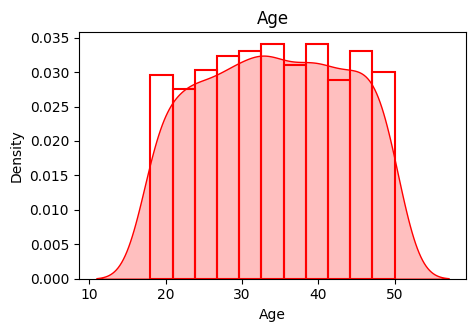

In [17]:
plt.figure(figsize = (5,3.2))
sns.kdeplot(data_eda, x = numerical_feature, fill = True, color = 'red')
sns.histplot(data_eda, x = numerical_feature, stat = 'density', fill = False, color = 'red')
plt.title(f"{numerical_feature}", color = 'black')
plt.show()

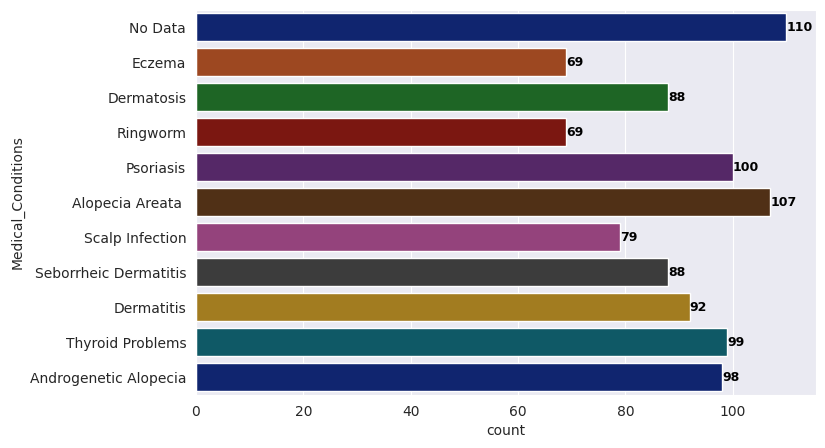

In [18]:
sns.set_style("darkgrid")
fig,ax = plt.subplots(figsize = (8,5))
ax = sns.countplot(data_eda, y = categorical_features[2], palette = 'dark')

for bars in ax.containers:
    ax.bar_label(bars, fontsize = 9, fontweight = 'bold', color = 'black')

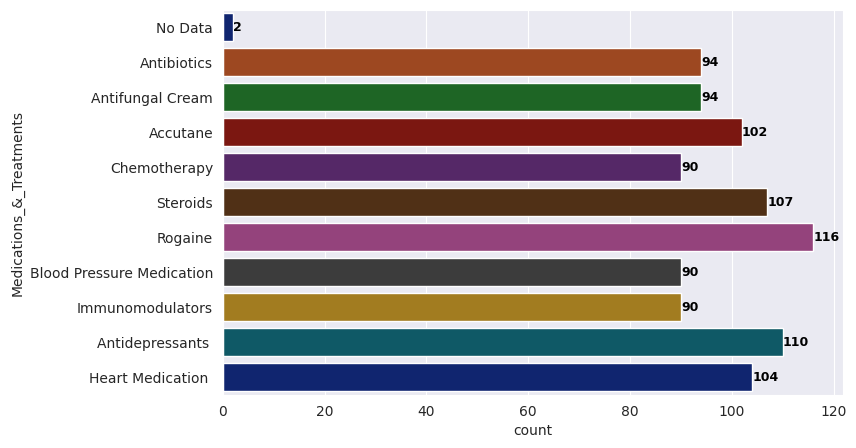

In [19]:
sns.set_style("darkgrid")
fig,ax = plt.subplots(figsize = (8,5))
ax = sns.countplot(data_eda, y = categorical_features[3], palette = 'dark')

for bars in ax.containers:
    ax.bar_label(bars, fontsize = 9, fontweight = 'bold', color = 'black')

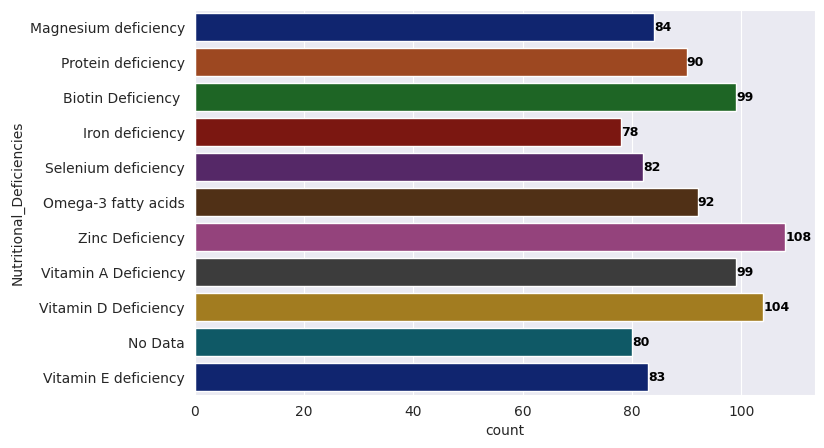

In [20]:
sns.set_style("darkgrid")
fig,ax = plt.subplots(figsize = (8,5))
ax = sns.countplot(data_eda, y = categorical_features[4], palette = 'dark')

for bars in ax.containers:
    ax.bar_label(bars, fontsize = 9, fontweight = 'bold', color = 'black')

In [21]:
fig = px.pie(data_eda[categorical_features[5]].value_counts().to_frame().reset_index(),
             values= categorical_features[5],
             names = 'index',
             title=f'{categorical_features[5]}')
fig.show()

In [22]:
fig = px.pie(data_eda[categorical_features[6]].value_counts().to_frame().reset_index(),
             values= categorical_features[6],
             names = 'index',
             title=f'{categorical_features[6]}')
fig.show()

In [23]:
fig = px.pie(data_eda[categorical_features[7]].value_counts().to_frame().reset_index(),
             values= categorical_features[7],
             names = 'index',
             title=f'{categorical_features[7]}')
fig.show()

In [24]:
fig = px.pie(data_eda[categorical_features[8]].value_counts().to_frame().reset_index(),
             values= categorical_features[8],
             names = 'index',
             title=f'{categorical_features[8]}')
fig.show()

In [25]:
fig = px.pie(data_eda[categorical_features[9]].value_counts().to_frame().reset_index(),
             values= categorical_features[9],
             names = 'index',
             title=f'{categorical_features[9]}')
fig.show()

In [26]:
fig = px.pie(data_eda[categorical_features[10]].value_counts().to_frame().reset_index(),
             values= categorical_features[10],
             names = 'index',
             title=f'{categorical_features[10]}')
fig.show()

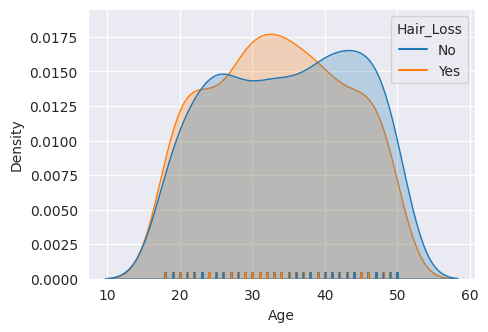

In [27]:
fig,ax = plt.subplots(figsize = (5,3.5))
sns.kdeplot(data_eda, x = 'Age', hue = 'Hair_Loss', fill = True, ax = ax)
sns.rugplot(data_eda, x = 'Age', hue = 'Hair_Loss', ax = ax)
fig.show()

In [28]:
data_eda.groupby('Hair_Loss')['Age'].describe().style.bar(color = 'blue', subset = ['mean', '50%'])

,count,mean,std,min,25%,50%,75%,max
Hair_Loss,,,,,,,,
No,502.000000,34.770916,9.592356,18.000000,26.000000,35.000000,43.000000,50.000000
Yes,497.000000,33.599598,9.128266,18.000000,26.000000,33.000000,41.000000,50.000000


# Machine Learning Implementation

In [29]:
X = data.drop(columns = ['Hair_Loss'])
y = data['Hair_Loss']

In [65]:
X_train, X_test, y_train, y_test = tts(X,
                                       y,
                                       test_size = 0.3,
                                       random_state = 1234,
                                       stratify = y)

In [66]:
Counter(y_train)

Counter({0: 351, 1: 348})

In [67]:
Counter(y_test)

Counter({0: 151, 1: 149})

In [68]:
numerical_predictor = X_train.select_dtypes(include = ['int', 'float']).columns.to_list()
categorical_predictors = X_train.select_dtypes(include = ['object', 'category']).columns.to_list()

In [69]:
preprocessor = ColumnTransformer([('te', TargetEncoder(min_samples_leaf = 1), categorical_predictors),
                                   ('kbins', KBinsDiscretizer(n_bins = 10,encode = 'onehot-dense', random_state = 1234), numerical_predictor)],
                                 remainder = 'passthrough',
                                 verbose_feature_names_out = False).set_output(transform = 'pandas')

X_train_prep = preprocessor.fit_transform(X_train, y_train)
X_test_prep = preprocessor.transform(X_test)

In [70]:
def f2_func(y_true, y_pred):
    f2_score = fbeta_score(y_true, y_pred, beta=2)
    return f2_score

def f2_scorer():
    return make_scorer(f2_func)

### Logistic Regression

In [71]:
lr = LogisticRegression(class_weight = 'balanced', random_state = 1234)
lr.fit(X_train_prep, y_train)

y_pred_train = lr.predict(X_train_prep)
y_pred_test = lr.predict(X_test_prep)

print(f'F2 Train: {fbeta_score(y_train, y_pred_train, beta = 2):.4f}')
print(f'F2 Test: {fbeta_score(y_test, y_pred_test, beta = 2):.4f}')

F2 Train: 0.6507
F2 Test: 0.6124


In [72]:
y_pred_test = lr.predict(X_test_prep)

report = classification_report(y_test, y_pred_test)
print("Classification Report:\n", report)

matrix= confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix: \n", matrix)

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.34      0.41       151
           1       0.49      0.65      0.56       149

    accuracy                           0.50       300
   macro avg       0.50      0.50      0.49       300
weighted avg       0.50      0.50      0.48       300

Confusion Matrix: 
 [[52 99]
 [52 97]]


### SVC (Support Vector Classifier)

In [56]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

label_encoder = LabelEncoder()
X_encoded = X.apply(label_encoder.fit_transform)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


param_grid = {'C': [0.1, 1, 10, 100, 1000]}


svc_classifier = SVC(kernel='rbf', random_state=42)


grid_search = GridSearchCV(svc_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_C = grid_search.best_params_['C']

svc_classifier_best = SVC(kernel='rbf', C=best_C, random_state=42)
svc_classifier_best.fit(X_train_scaled, y_train)

y_pred = svc_classifier_best.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Best C:", best_C)
print("Accuracy:", accuracy)


Best C: 100
Accuracy: 0.545


In [43]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = svc_classifier_best.predict(X_test_scaled)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", matrix)


Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.63      0.55        89
           1       0.62      0.48      0.54       111

    accuracy                           0.55       200
   macro avg       0.55      0.55      0.54       200
weighted avg       0.56      0.55      0.54       200

Confusion Matrix:
 [[56 33]
 [58 53]]


### KNN (K Nearest Neighbors)

In [53]:
from sklearn.preprocessing import OneHotEncoder

X_encoded = pd.get_dummies(X)

encoder = OneHotEncoder()

X_train_prep = encoder.fit_transform(X_train)

X_test_prep = encoder.transform(X_test)

def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 5, 100),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['minkowski', 'cosine', 'euclidean', 'manhattan', 'l2'])
    }

    estimator = KNeighborsClassifier(**params, n_jobs=-1)


    score = cross_val_score(estimator, X=X_train_prep, y=y_train,
                            scoring=f2_scorer(),
                            cv=StratifiedKFold(n_splits=10),
                            n_jobs=-1)

    f2 = score.mean()

    return f2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200, show_progress_bar=True)

best_params = study.best_params
print("Best parameters:", best_params)


best_knn_classifier = KNeighborsClassifier(**best_params, n_jobs=-1)
best_knn_classifier.fit(X_train_prep, y_train)


y_pred_train = best_knn_classifier.predict(X_train_prep)

y_pred_test = best_knn_classifier.predict(X_test_prep)


f2_train = fbeta_score(y_train, y_pred_train, beta=2)
print(f'F2 Train: {f2_train:.4f}')


f2_test = fbeta_score(y_test, y_pred_test, beta=2)
print(f'F2 Test: {f2_test:.4f}')


[I 2024-03-31 19:22:43,830] A new study created in memory with name: no-name-71c59f3b-bce0-467b-aea4-20dddd148ee8


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-03-31 19:22:47,500] Trial 0 finished with value: 0.5335298963698322 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.5335298963698322.
[I 2024-03-31 19:22:47,786] Trial 1 finished with value: 0.5670252612588764 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 1 with value: 0.5670252612588764.
[I 2024-03-31 19:22:48,065] Trial 2 finished with value: 0.44612126261707025 and parameters: {'n_neighbors': 58, 'weights': 'distance', 'metric': 'cosine'}. Best is trial 1 with value: 0.5670252612588764.
[I 2024-03-31 19:22:48,321] Trial 3 finished with value: 0.3967935761630424 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'l2'}. Best is trial 1 with value: 0.5670252612588764.
[I 2024-03-31 19:22:48,573] Trial 4 finished with value: 0.5237045669226028 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 1 with value

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# Generate confusion matrix
print("Confusion Matrix:")
conf_mat = confusion_matrix(y_test, y_pred_test)
print(conf_mat)


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.47      0.49       149
           1       0.51      0.55      0.53       151

    accuracy                           0.51       300
   macro avg       0.51      0.51      0.51       300
weighted avg       0.51      0.51      0.51       300

Confusion Matrix:
[[70 79]
 [68 83]]
